In [5]:
"""
On VGG Face2
refereces : https://github.com/adambielski/siamese-triplet
"""
import os
import sys
from glob import glob
# 이 파일의 Directory의 절대 경로
__file__path = os.path.abspath("")
print(__file__path)
sys.path.append(__file__path)

import numpy as np

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import Dataset

# Configuration 
from omegaconf import DictConfig, OmegaConf
import hydra
config_path = "./configs"
config_name = "config.yaml"
try: hydra.initialize(version_base=None, 
                      config_path=config_path)
except: pass
cfg = hydra.compose(config_name=config_name)
print(OmegaConf.to_yaml(cfg))

/Users/kackaobank1/Desktop/dev/FaceSwap/swappers/SmoothSwap
train:
  isTrain: false
  end_epoch: 1000
  batch_size: 512
  optimizer: adam
  weight_decay: 0.0005
  momentum: 0.9
  lr: 0.001
  lr_step: 10
  log_dir: ./logs
  checkpoint_dir: ./checkpoints
  device: cpu
id_emb:
  image_size: 224
  train_embedder: false
  network: resnet50
  emb_size: 512
  checkpoint_path: ''
generator:
  image_size: 256
  num_feature_init: 64
discriminator:
  image_size: 256
authur:
  name: conor.k
  version: 0.0.1



/Users/kackaobank1/.pyenv/versions/3.8.10/envs/python3.8/lib/python3.8/site-packages/hydra/_internal/defaults_list.py:251: UserWarning: In 'config.yaml': Defaults list is missing `_self_`. See https://hydra.cc/docs/upgrades/1.0_to_1.1/default_composition_order for more information
  warnings.warn(msg, UserWarning)


#### Fix random seed

In [6]:
random_seed = 777

# torch random 값 생성
torch.manual_seed(random_seed)
# # 현 gpu에서의 random 값 생성 \ 
# torch.cuda.manual_seed(random_seed)
# # 2개 이상의 gpu를 사용할 때
# torch.cuda.manual_seed_all(random_seed)
# # randomness가 들어간 함수 미사용
# torch.backends.cudnn.deterministic = True
# # True일 시, 동일한 사이즈에 텐서들이 들어올때의 속도향상을 불러온다.
# torch.backends.cudnn.benchmark = False
# numpy의 random seed 고정
np.random.seed(random_seed)
# random 라이브러리의 seed 고정`
import random
random.seed(random_seed)

In [7]:
#### model build test
# !python ./models/id_emb.py

from models.id_emb import IdEmbedder

embedder = IdEmbedder(cfg)

Using cache found in /Users/kackaobank1/.cache/torch/hub/pytorch_vision_v0.10.0
/Users/kackaobank1/.pyenv/versions/3.8.10/envs/python3.8/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [8]:
from torchsummary import summary
summary(embedder, input_size=(3, 224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

#### Dataloader

In [9]:
# train_test_split 
# data_dir => train_data_dir, test_data_dir

def get_train_test_set_vggface(data_dir, ratio_of_test=0.3):
    """
    example
        data_dir = "../../data/vggface2_crop_arcfacealign_224/"
    """
    all_pictures = glob(data_dir+"/*/*.jpg")

    test_size = int(len(all_pictures) * ratio_of_test)

    test_set = np.random.choice(all_pictures, size=test_size)
    train_set = list(set(all_pictures) - set(test_set))
    
    return np.array(train_set), test_set

def get_label_dict_vggface(data_dir):
    all_label = glob(data_dir+"/*")
    return {os.path.basename(name) : label for label, name in enumerate(all_label)}


In [10]:
data_dir = "../../data/vggface2_crop_arcfacealign_224/"

label_dict = get_label_dict_vggface(data_dir)
train_set, test_set = get_train_test_set_vggface(data_dir, 0.2)

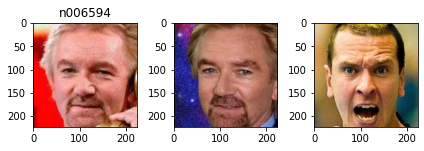

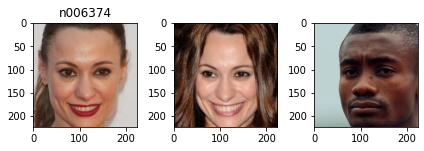

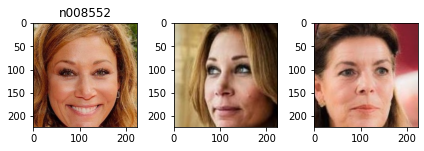

In [11]:
from torch.utils.data import Dataset
from PIL import Image

class VGGFace2Dataset(Dataset):
    def __init__(self, data_set, label_dict, transform=None):
        self.data_set = data_set
        self.label_dict = label_dict
        self.label_dict_inv = {v:k for k, v in label_dict.items()}
        self.label_keys = list(label_dict.keys())
        self.transform = transform
        
    def __len__(self):
        return len(self.data_set)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
            
        img_path = self.data_set[idx]
        
        img_dir = os.path.dirname(img_path)
        id_idx = os.path.basename(img_dir)
        label = self.label_dict[id_idx]
        
        # random pick positive
        pos_path = np.random.choice(glob(img_dir + "/*.jpg"))
        # random pick negative
        neg_idx = np.random.choice([x for x in self.label_keys if x != id_idx])
        neg_path = np.random.choice(glob(os.path.dirname(img_dir) + "/" + str(neg_idx) + "/*.jpg"))

        image = Image.open(img_path)
        posit = Image.open(pos_path)
        negat = Image.open(neg_path)
        
        img1 = image
        img2 = posit
        img3 = negat

        if self.transform is not None:
            img1 = self.transform(img1)
            img2 = self.transform(img2)
            img3 = self.transform(img3)

        return (img1, img2, img3), label

def test_VGGFace2Dataset(data_set, label_dict):
    import matplotlib.pyplot as plt     
    vgg_dataset = VGGFace2Dataset(data_set, label_dict)

    for i in np.random.randint(len(vgg_dataset), size=3):
        sample, label = vgg_dataset[i]
    
        plt.subplot(1, 3, 1)
        plt.title(vgg_dataset.label_dict_inv[label])
        plt.imshow(sample[0])
        plt.subplot(1, 3, 2)
        plt.imshow(sample[1])
        plt.subplot(1, 3, 3)
        plt.imshow(sample[2])
        plt.tight_layout()
        plt.show()

test_VGGFace2Dataset(train_set, label_dict)

In [12]:
transform = transforms.Compose([
    transforms.ToTensor()
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
])

In [13]:
train_dataset = VGGFace2Dataset(train_set, label_dict, transform=transform)
test_dataset  = VGGFace2Dataset(test_set,  label_dict, transform=transform)

In [14]:
batch_size = 8

train_loader = torch.utils.data.DataLoader(train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=False)

test_loader = torch.utils.data.DataLoader(test_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=False)

#### Training logic

In [15]:
class TripletNet(nn.Module):
    def __init__(self, embedding_net):
        super(TripletNet, self).__init__()
        self.embedding_net = embedding_net

    def forward(self, x1, x2, x3):
        output1 = self.embedding_net(x1)
        output2 = self.embedding_net(x2)
        output3 = self.embedding_net(x3)
        return output1, output2, output3

    def get_embedding(self, x):
        return self.embedding_net(x)
    

class TripletLoss(nn.Module):
    """
    Triplet loss
    Takes embeddings of an anchor sample, a positive sample and a negative sample
    """

    def __init__(self, margin):
        super(TripletLoss, self).__init__()
        self.margin = margin

    def forward(self, anchor, positive, negative, size_average=True):
        distance_positive = (anchor - positive).pow(2).sum(1)  # .pow(.5)
        distance_negative = (anchor - negative).pow(2).sum(1)  # .pow(.5)
        losses = F.relu(distance_positive - distance_negative + self.margin)
        return losses.mean() if size_average else losses.sum()


In [16]:
n_epochs = 20
log_interval = 500
margin = 1.
cuda = torch.cuda.is_available()

model = TripletNet(embedder)
if cuda:
    model.cuda()

loss_fn = TripletLoss(margin)
lr = 1e-3
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = optim.lr_scheduler.StepLR(optimizer, 8, gamma=0.1, last_epoch=-1)

In [36]:
def train_epoch(train_loader, 
                model, 
                loss_fn, 
                optimizer, 
                cuda, 
                log_interval,
                metrics):
    
    for metric in metrics:
        metric.reset()

    model.train()
    losses = []
    total_loss = 0

    for batch_idx, sample in enumerate(train_loader):
        data, label = sample
        if cuda:
            data = tuple(d.cuda() for d in data)
            
        optimizer.zero_grad()
        outputs = model(*data)
        
        loss_outputs = loss_fn(*outputs)
        
        loss = loss_outputs[0] if type(loss_outputs) in (tuple, list) else loss_outputs
        losses.append(loss.item())
        total_loss += loss.item()
        loss.backward()
        optimizer.step()

        for metric in metrics:
            metric(outputs, target, loss_outputs)

        if batch_idx % log_interval == 0:
            message = 'Train: [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                batch_idx * len(data[0]), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), np.mean(losses))
            for metric in metrics:
                message += '\t{}: {}'.format(metric.name(), metric.value())

            print(message, end="\r")
            losses = []

    total_loss /= (batch_idx + 1)
    return total_loss, metrics


def test_epoch(val_loader, model, loss_fn, cuda, metrics):
    with torch.no_grad():
        for metric in metrics:
            metric.reset()
        model.eval()
        val_loss = 0
        for batch_idx, (data, target) in enumerate(val_loader):
            if cuda:
                data = tuple(d.cuda() for d in data)
                
            outputs = model(*data)

            loss_inputs = outputs
            loss_outputs = loss_fn(*loss_inputs)
            
            loss = loss_outputs[0] if type(loss_outputs) in (tuple, list) else loss_outputs
            val_loss += loss.item()
            
            for metric in metrics:
                metric(outputs, target, loss_outputs)
                
    return val_loss, metrics

def fit(train_loader, 
        val_loader, 
        model, 
        loss_fn, 
        optimizer, 
        scheduler, 
        n_epochs, 
        cuda, 
        log_interval,
        checkpoint_dir="./checkpoints/id_emb",
        metrics=[],
        start_epoch=0):

    for epoch in range(0, start_epoch):
        scheduler.step()

    for epoch in range(start_epoch, n_epochs):
        scheduler.step()

        # Train stage
        train_loss, metrics = train_epoch(train_loader, model, loss_fn, optimizer, cuda, log_interval, metrics)

        message = 'Epoch: {}/{}. Train set: Average loss: {:.4f}'.format(epoch + 1, n_epochs, train_loss)
        for metric in metrics:
            message += '\t{}: {}'.format(metric.name(), metric.value())
            
        val_loss, metrics = test_epoch(val_loader, model, loss_fn, cuda, metrics)
        val_loss /= len(val_loader)

        message += '\nEpoch: {}/{}. Validation set: Average loss: {:.4f}'.format(epoch + 1, 
                                                                                 n_epochs,
                                                                                 val_loss)
        for metric in metrics:
            message += '\t{}: {}'.format(metric.name(), metric.value())
        print(message)
        state = {'epoch': epoch,
                 'model': model,
                 'optimizer': optimizer}
        filename = os.path.join(checkpoint_dir, 
                                'cpt_' + str(epoch) + '_' + "{:.4f}".format(val_loss) + '.tar')
        torch.save(state, filename)
        print("{} is saved".format(filename))

In [37]:
fit(train_loader, 
    test_loader,
    model,
    loss_fn, 
    optimizer, 
    scheduler, 
    n_epochs, 
    cuda, 
    log_interval)

./checkpoints/id_emb/cpt_0_0.0330.tar is saved
./checkpoints/id_emb/cpt_1_0.0330.tar is saved
./checkpoints/id_emb/cpt_2_0.0330.tar is saved
./checkpoints/id_emb/cpt_3_0.0330.tar is saved
./checkpoints/id_emb/cpt_4_0.0330.tar is saved
./checkpoints/id_emb/cpt_5_0.0330.tar is saved
./checkpoints/id_emb/cpt_6_0.0330.tar is saved
./checkpoints/id_emb/cpt_7_0.0330.tar is saved
./checkpoints/id_emb/cpt_8_0.0330.tar is saved
./checkpoints/id_emb/cpt_9_0.0330.tar is saved
./checkpoints/id_emb/cpt_10_0.0330.tar is saved
./checkpoints/id_emb/cpt_11_0.0330.tar is saved
./checkpoints/id_emb/cpt_12_0.0330.tar is saved
./checkpoints/id_emb/cpt_13_0.0330.tar is saved
./checkpoints/id_emb/cpt_14_0.0330.tar is saved
./checkpoints/id_emb/cpt_15_0.0330.tar is saved
./checkpoints/id_emb/cpt_16_0.0330.tar is saved
./checkpoints/id_emb/cpt_17_0.0330.tar is saved
./checkpoints/id_emb/cpt_18_0.0330.tar is saved


RuntimeError: [enforce fail at inline_container.cc:319] . unexpected pos 126122496 vs 126122388

In [11]:
# utils
class AverageMeter():
    """
    Keeps track of most recent, average, sum, and count of a metric.
    """

    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count
        
def save_checkpoint(epoch, epochs_since_improvement, model, metric_fc, optimizer, acc, is_best):
    print('saving checkpoint ...')
    state = {'epoch': epoch,
             'epochs_since_improvement': epochs_since_improvement,
             'acc': acc,
             'model': model,
             'metric_fc': metric_fc,
             'optimizer': optimizer}
    # filename = 'checkpoint_' + str(epoch) + '_' + str(loss) + '.tar'
    filename = 'checkpoint.tar'
    torch.save(state, filename)
    # If this checkpoint is the best so far, store a copy so it doesn't get overwritten by a worse checkpoint
    if is_best:
        torch.save(state, 'BEST_checkpoint.tar')
        
def accuracy(scores, targets, k=1):
    batch_size = targets.size(0)
    _, ind = scores.topk(k, 1, True, True)
    correct = ind.eq(targets.view(-1, 1).expand_as(ind))
    correct_total = correct.view(-1).float().sum()  # 0D tensor
    return correct_total.item() * (100.0 / batch_size)

def get_logger():
    logger = logging.getLogger()
    handler = logging.StreamHandler()
    formatter = logging.Formatter("%(asctime)s %(levelname)s \t%(message)s")
    handler.setFormatter(formatter)
    logger.addHandler(handler)
    logger.setLevel(logging.INFO)
    return logger

def full_log(epoch):
    full_log_dir = 'data/full_log'
    if not os.path.isdir(full_log_dir):
        os.mkdir(full_log_dir)
    filename = 'angles_{}.txt'.format(epoch)
    dst_file = os.path.join(full_log_dir, filename)
    src_file = 'data/angles.txt'
    copyfile(src_file, dst_file)